In [3]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple, Counter as count
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from hyperloglog import HyperLogLog
from pyod.models.knn import KNN
from abc import abstractmethod
from nltk.util import ngrams
from pathlib import Path
from enum import IntEnum
import pandas as pd
import numpy as np
import copy
import time


np.random.seed(42)


def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('%r took %2.2f ms' % (method.__name__, (te - ts) * 1000))
        return result
    return timed


class Quality(IntEnum):
    GOOD = 0
    BAD = 1


class Learner:
    @abstractmethod
    def fit(history):
        pass

    @abstractmethod
    def predict(X):
        pass


class KNNLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn
        self.clf = None

    def fit(self, history):
        learner = KNN(contamination=.01,
                      n_neighbors=5,
                      method='mean',
                      metric='euclidean',
                      algorithm='ball_tree')
        self.clf = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        return self

    def predict(self, X):
        assert self.clf is not None, ".fit first"
        return self.clf.predict(X)


class DataProfiler:
    class __DP:
        def __init__(self):
            self.analyzer = {
                "Completeness": lambda x: self.completeness(x),
                "Uniqueness": lambda x: self.uniqueness(x),
                "ApproxCountDistinct": lambda x: self.approx_count_distinct(x),
                "Mean": lambda x: np.mean(x),
                "Minimum": lambda x: np.min(x),
                "Maximum": lambda x: np.max(x),
                "StandardDeviation": lambda x: np.std(x),
                "Sum": lambda x: np.sum(x),
                "Count": lambda x: x.shape[0],
                "FrequentRatio": lambda x: 1.*max(count(x).values())/x.shape[0],
                "PeculiarityIndex": lambda x: self.peculiarity(x),
            }

            self.dtype_checking = {
                "int64": True,
                "float64": True
            }


        def completeness(self, x):
            return 1. - np.sum(pd.isna(x)) / x.shape[0]

        def uniqueness(self, x):
            tmp = [i for i in count(x).values() if i == 1]
            return 1. * np.sum(tmp) / x.shape[0]

        def count_distinct(self, x):
            return 1. * len(count(x).keys()) / x.shape[0]

        def approx_count_distinct(self, x):
            hll = HyperLogLog(.01)
            for idx, val in x.items():
                hll.add(str(val))
            return len(hll)

        # TODO: count sketch, using deterministic count for small data
#        def count_sketch(self, matrix, sketch_size=50):
#            m, n = matrix.shape[0], 1
#            res = np.zeros([m, sketch_size])
#            hashedIndices = np.random.choice(sketch_size, replace=True)
#            print(hashedIndices)
#            randSigns = np.random.choice(2, n, replace=True) * 2 - 1 # a n-by-1{+1, -1} vector
#            matrix = matrix * randSigns
#            for i in range(sketch_size):
#                res[:, i] = np.sum(matrix[:, hashedIndices == i], 1)
#            return res

        def peculiarity(self, x):
            def _peculiarity_index(word, count2grams, count3grams):
                t = []
                for xyz in ngrams(str(word), 3):
                    xy, yz = xyz[:2], xyz[1:]
                    cxy, cyz = count2grams.get(xy, 0), count2grams.get(yz, 0)
                    cxyz = count3grams.get(xyz, 0)
                    t.append(.5* (np.log(cxy) + np.log(cyz) - np.log(cxyz)))
                return np.sqrt(np.mean(np.array(t)**2))

            aggregated_string = " ".join(map(str, x))
            c2gr = count(ngrams(aggregated_string, 2))
            c3gr = count(ngrams(aggregated_string, 3))
            return x.apply(lambda y: _peculiarity_index(y, c2gr, c3gr)).max()

    instance = None

    def __init__(self):
        if not DataProfiler.instance:
            DataProfiler.instance = DataProfiler.__DP()

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def _compute_for_column(self, column, *analyzers):
        return [self.instance.analyzer[name](column) for name in analyzers]

    # @timeit
    def compute_for(self, batch, return_labels=False):
        profile, labels = [], []
        generic_metrics = ["Completeness", "Uniqueness", "ApproxCountDistinct", "FrequentRatio"]
        numeric_metrics = ["Mean", "Minimum", "Maximum", "StandardDeviation", "Sum"]

        for col, dtype in zip(batch.columns, batch.dtypes):
            # For every column, compute generic metrics,
            # add additional numeric metrics for numeric columns
            metrics = copy.deepcopy(generic_metrics)
            if dtype in ['int64', 'float64']:
                metrics.extend(numeric_metrics)
            elif dtype == 'object':  # Check for likely-to-be-strings
                metrics.append("PeculiarityIndex")
            # Compute the metrics for each column
            column_profile = self._compute_for_column(batch[col], *metrics)
            profile.extend(column_profile)
            labels.extend([f'{col}_{m}' for m in metrics])
        return profile if not return_labels else (profile, labels)

    def compute_completenness(self, batch, return_labels=False):
        profile, labels = [], []
        for col in batch.columns:
            # Only compute completeness for each column
            completeness_value = self.instance.analyzer["Completeness"](batch[col])
            profile.append(completeness_value)
            labels.append(f'{col}_Completeness')

        return profile if not return_labels else (profile, labels)
    
class DataQualityValidatior:
    def __init__(self):
        self.clf = KNNLearner()
        self.history = []

    def add(self, batch):
        self.history.append(batch)
        return self

    def test(self, batch):
        # print(len(self.history))
        # re-fit the model from scratch
        self.clf.fit(self.history)

        decision = self.clf.predict([batch])
        return Quality.GOOD if int(decision) == 0 else Quality.BAD


Batch = namedtuple('Batch', 'id clean dirty')

def get_batch_fnames():
    folder = Path('/../partitions/')
    batches = []
    for day in range(1, 54):
        fclean = folder / f'/../../clean/FBPosts_clean_{day}.tsv'
        fdirty = folder / f'/../../dirty/FBPosts_dirty_{day}.tsv'
        assert fclean.exists()
        assert fdirty.exists()
        batches.append(Batch(day, fclean, fdirty))
    return iter(batches)


def good_or_bad(batch):
    return np.random.choice([Quality.GOOD, Quality.BAD], p=[9./10, 1./10])

def demo():
    dqv = DataQualityValidatior()
    batches = get_batch_fnames()
    correct_predictions = 0
    total_predictions = 0
    
    # initial training set
    for day in range(8):
        batch = next(batches)
        # TODO: provide functionality to read the data
        # in the FBPosts case, .tsv files
        batch_data = pd.read_csv(batch.clean, sep='\t')
        profile = DataProfiler().compute_for(batch_data)
        dqv.add(profile)

    # testing phase
    for day in range(20):
        batch = next(batches)
        real_quality = good_or_bad(batch)
        fname = batch.clean if real_quality == Quality.GOOD else batch.dirty
        batch_data = pd.read_csv(fname, sep='\t')
        profile = DataProfiler().compute_for(batch_data)

        predicted_quality = dqv.test(profile)
        if predicted_quality == real_quality:
            correct_predictions += 1
        total_predictions += 1

        if predicted_quality == Quality.GOOD:
            dqv.add(profile)
        else:
            # TODO: Alarm, debugging, fixing, pass if false alarm
            print(f'**** Potential problem with batch #{batch.id}!')
            fixed_data = pd.read_csv(batch.clean, sep='\t')
            fixed_profile = DataProfiler().compute_for(fixed_data)
            dqv.add(fixed_profile)


if __name__ == "__main__":
    demo()

AssertionError: 

## Completeness selon scalabilite 

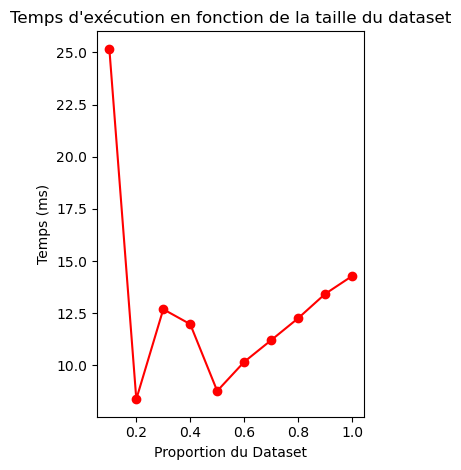

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time


def read_dataset(filepath):
    return pd.read_csv(filepath)

def compute_completeness_and_time(data, column_name, proportions):
    completeness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        completeness = DataProfiler().compute_completenness(batch[[column_name]])
        end_time = time.time()
        completeness_scores.append(completeness[0])
        times.append((end_time - start_time)*1000) 
    return completeness_scores, times

# Chemin vers le dataset
dataset_path = 'archive/combined_dataset.csv'
taxi_data = read_dataset(dataset_path)

# Proportions du dataset à analyser
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Calcul de la complétude et du temps d'exécution
completeness_scores, times = compute_completeness_and_time(taxi_data, 'taxi_id', proportions)

# Création du graphique
plt.figure()


plt.subplot(1, 2, 2)
plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (ms)')

plt.tight_layout()
plt.show()


## Uniqueness selon scalability 

In [3]:
def compute_uniqueness(batch, return_labels=False):
    uniqueness_scores, labels = [], []
    for col in batch.columns:
        # Calculer l'unicité pour chaque colonne
        uniqueness_value = DataProfiler().uniqueness(batch[col])
        uniqueness_scores.append(uniqueness_value)
        labels.append(f'{col}_Uniqueness')

    return uniqueness_scores if not return_labels else (uniqueness_scores, labels)


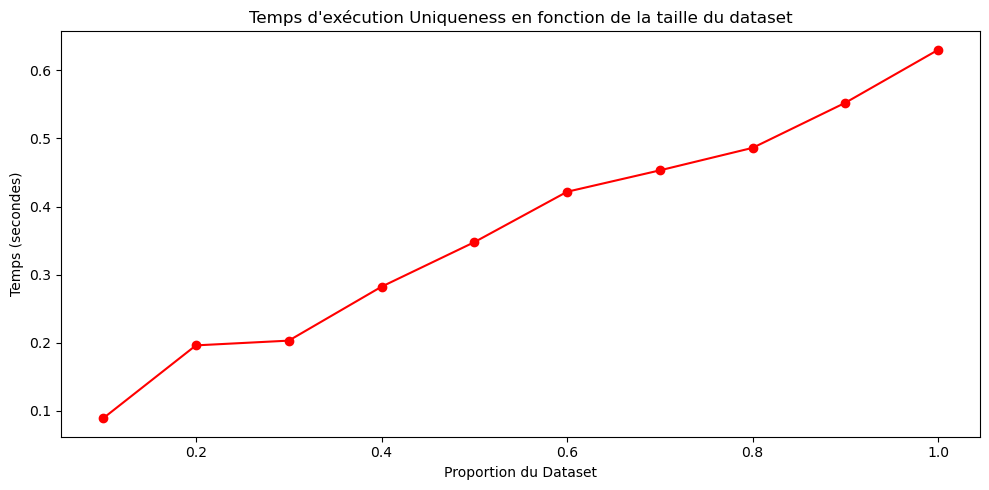

In [4]:
def compute_uniqueness_and_time(data, column_name, proportions):
    uniqueness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        uniqueness = compute_uniqueness(batch[[column_name]])
        end_time = time.time()
        uniqueness_scores.append(uniqueness[0])
        times.append(end_time - start_time)  # Temps en secondes
    return uniqueness_scores, times


uniqueness_scores, times = compute_uniqueness_and_time(taxi_data, 'trip_miles', proportions)

# Création du graphique
plt.figure(figsize=(10, 5))

plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution Uniqueness en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (secondes)')

plt.tight_layout()
plt.show()

In [18]:
taxi_data.count()

taxi_id                              3873985
trip_start_timestamp                 3874059
trip_end_timestamp                   3873755
trip_seconds                         3873483
trip_miles                           3874041
pickup_census_tract                        0
dropoff_census_tract                 2235144
pickup_community_area                3220386
dropoff_community_area               3158099
fare                                 3874013
tips                                 3874013
tolls                                3874013
extras                               3874013
trip_total                           3874013
payment_type                         3874059
company                              2443837
pickup_latitude                      3220457
pickup_longitude                     3220457
dropoff_latitude                     3162971
dropoff_longitude                    3162971
INTEGER                                    0
A unique identifier for the taxi.          0
dtype: int

## Approx Count Distinct and Pecularity

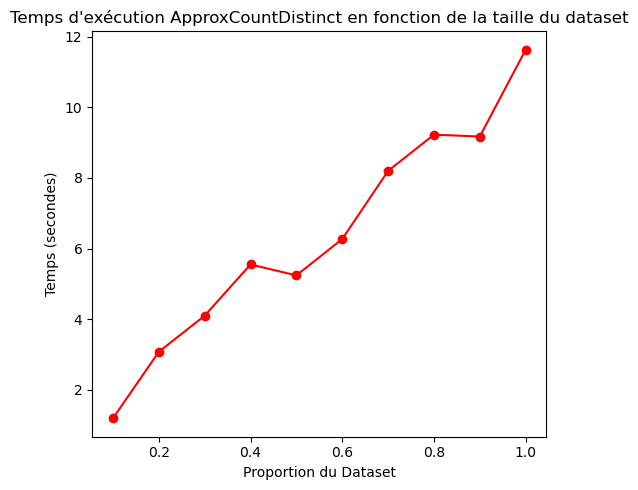

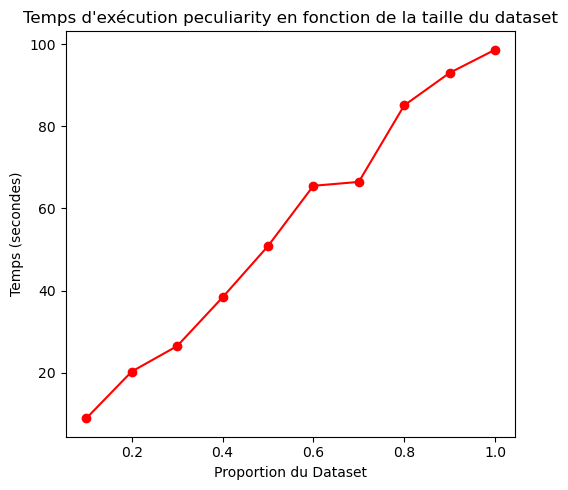

In [5]:
def compute_approx_count_distinct(batch, return_labels=False):
    uniqueness_scores, labels = [], []
    for col in batch.columns:
        # Calculer l'unicité pour chaque colonne
        uniqueness_value = DataProfiler().approx_count_distinct(batch[col])
        uniqueness_scores.append(uniqueness_value)
        labels.append(f'{col}_Uniqueness')

    return uniqueness_scores if not return_labels else (uniqueness_scores, labels)

def compute_approx_count_distinct_and_time(data, column_name, proportions):
    uniqueness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        uniqueness = compute_approx_count_distinct(batch[[column_name]])
        end_time = time.time()
        uniqueness_scores.append(uniqueness[0])
        times.append(end_time - start_time)  # Temps en secondes
    return uniqueness_scores, times


uniqueness_scores, times = compute_approx_count_distinct_and_time(taxi_data, 'trip_miles', proportions)

# Création du graphique
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution ApproxCountDistinct en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (secondes)')

plt.tight_layout()
plt.show()

#################################################

def compute_peculiarity(batch, return_labels=False):
    uniqueness_scores, labels = [], []
    for col in batch.columns:
        # Calculer l'unicité pour chaque colonne
        uniqueness_value = DataProfiler().peculiarity(batch[col])
        uniqueness_scores.append(uniqueness_value)
        labels.append(f'{col}_Uniqueness')

    return uniqueness_scores if not return_labels else (uniqueness_scores, labels)

def compute_peculiarity_and_time(data, column_name, proportions):
    uniqueness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        uniqueness = compute_peculiarity(batch[[column_name]])
        end_time = time.time()
        uniqueness_scores.append(uniqueness[0])
        times.append(end_time - start_time)  # Temps en secondes
    return uniqueness_scores, times


uniqueness_scores, times = compute_peculiarity_and_time(taxi_data, 'trip_miles', proportions)

# Création du graphique
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution peculiarity en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (secondes)')

plt.tight_layout()
plt.show()

## Contraintes d'integrite Consistency 

In [7]:
df = pd.read_csv('archive/combined_dataset.csv', parse_dates=['trip_start_timestamp', 'trip_end_timestamp'])

def coherence_temporelle(df):
    return (df['trip_end_timestamp'] > df['trip_start_timestamp']).mean()

def coherence_duree(df):
    duree_reelle = (df['trip_end_timestamp'] - df['trip_start_timestamp']).dt.total_seconds()
    duree_declaree = df['trip_seconds']
    # Tolérance en secondes pour les différences de durée
    tolerance = 60 
    return ((duree_declaree - duree_reelle).abs() <= tolerance).mean()

def coherence_tarifs(df):
    # Hypothèse: tarif minimum de $2.50 et $0.50 par mile
    tarif_estime = 2.50 + df['trip_miles'] * 0.50
    # Vérifier si le tarif réel est proche du tarif estimé (tolérance de 20% par exemple)
    return ((df['fare'] / tarif_estime).between(0.8, 1.2)).mean()

def verification_coordonnees(df):
    # Exemple de coordonnées valides pour Chicago
    latitude_range = (41.6, 42.1)
    longitude_range = (-88.0, -87.5)
    valid_pickup = df['pickup_latitude'].between(*latitude_range) & df['pickup_longitude'].between(*longitude_range)
    valid_dropoff = df['dropoff_latitude'].between(*latitude_range) & df['dropoff_longitude'].between(*longitude_range)
    return (valid_pickup & valid_dropoff).mean()

# Calcul des métriques
temporelle = coherence_temporelle(df)
duree = coherence_duree(df)
tarifs = coherence_tarifs(df)
coordonnees = verification_coordonnees(df)

# Affichage des résultats
print(f"Cohérence Temporelle: {temporelle:.2f}")
print(f"Cohérence de la Durée de Trajet: {duree:.2f}")
print(f"Cohérence des Tarifs: {tarifs:.2f}")
print(f"Vérification des Coordonnées Géographiques: {coordonnees:.2f}")


Cohérence Temporelle: 0.56
Cohérence de la Durée de Trajet: 0.21
Cohérence des Tarifs: 0.00
Vérification des Coordonnées Géographiques: 0.00


In [6]:
print("Completeness taxi_id : "+str(DataProfiler().completeness(taxi_data['taxi_id'])))
print("Completeness dropoff_community_area : "+ str(DataProfiler().completeness(taxi_data['dropoff_community_area'])))
print("Completeness dropoff_census_tract : "+str(DataProfiler().completeness(taxi_data['dropoff_census_tract'])))

Completeness taxi_id : 0.999980898587244
Completeness dropoff_community_area : 0.8151912503139472
Completeness dropoff_census_tract : 0.5769514609870423


# 

## Tests Overview

In [55]:
(mydf["pickup_census_tract"].unique())

array([nan])

In [14]:
# Step 1: Define the dataset path and chunk size
dataset_path = 'chicago_taxi_trips_2016_01.csv'
chunk_size = 10000  # Adjust based on your system's memory capacity

# Step 2: Initialize variables to store aggregated statistics
aggregated_stats = {}
chunk_count = 0

# Step 3: Process the dataset in chunks
for chunk in pd.read_csv(dataset_path, chunksize=chunk_size):
    chunk_count += 1
    profiler = DataProfiler()

    # Compute profile for the current chunk
    profile, labels = profiler.compute_for(chunk, return_labels=True)
    # Aggregate statistics
    for label, value in zip(labels, profile):
        if label not in aggregated_stats:
            aggregated_stats[label] = []
        aggregated_stats[label].append(value)
# Step 4: Combine the statistics from all chunks
final_stats = {label: np.mean(values) for label, values in aggregated_stats.items()}
final_stats_df = pd.DataFrame([final_stats])

In [15]:
final_stats_df

,taxi_id_Completeness,taxi_id_Uniqueness,taxi_id_ApproxCountDistinct,taxi_id_FrequentRatio,trip_start_timestamp_Completeness,trip_start_timestamp_Uniqueness,trip_start_timestamp_ApproxCountDistinct,trip_start_timestamp_FrequentRatio,trip_start_timestamp_PeculiarityIndex,trip_end_timestamp_Completeness,...,pickup_longitude_ApproxCountDistinct,pickup_longitude_FrequentRatio,dropoff_latitude_Completeness,dropoff_latitude_Uniqueness,dropoff_latitude_ApproxCountDistinct,dropoff_latitude_FrequentRatio,dropoff_longitude_Completeness,dropoff_longitude_Uniqueness,dropoff_longitude_ApproxCountDistinct,dropoff_longitude_FrequentRatio
0,0.999987,0.11984,3797.25731,0.001274,1.0,0.046023,2564.497076,0.001644,5.137271,0.999927,...,182.116959,0.101919,0.817259,0.187948,239.573099,0.085784,0.817259,0.187948,237.421053,0.085784


In [21]:

# Step 1: Extract metrics and variable names
metrics = set()
variables = set()

for col in final_stats_df.columns:
    var, metric = col.rsplit('_', 1)
    metrics.add(metric)
    variables.add(var)

In [22]:
metrics

{'ApproxCountDistinct',
 'Completeness',
 'FrequentRatio',
 'PeculiarityIndex',
 'Uniqueness'}

In [23]:
variables

{'company',
 'dropoff_census_tract',
 'dropoff_community_area',
 'dropoff_latitude',
 'dropoff_longitude',
 'extras',
 'fare',
 'payment_type',
 'pickup_census_tract',
 'pickup_community_area',
 'pickup_latitude',
 'pickup_longitude',
 'taxi_id',
 'tips',
 'tolls',
 'trip_end_timestamp',
 'trip_miles',
 'trip_seconds',
 'trip_start_timestamp',
 'trip_total'}

In [27]:
# Nombre de variables dans reshaped_data
num_variables = len(reshaped_data['Variable'])

# Initialisation des listes pour chaque métrique avec None
for metric in reshaped_data:
    if metric != 'Variable':  # On ne modifie pas la liste des variables
        reshaped_data[metric] = [None] * num_variables

# Création du DataFrame avec les listes de même longueur
reshaped_df = pd.DataFrame(reshaped_data)
reshaped_df.head()

,ApproxCountDistinct,Uniqueness,FrequentRatio,Completeness,PeculiarityIndex,Variable
0,None,None,None,None,None,trip_seconds
1,None,None,None,None,None,trip_miles
2,None,None,None,None,None,trip_total
3,None,None,None,None,None,tolls
4,None,None,None,None,None,trip_start_timestamp


In [33]:
# # Nombre de variables dans reshaped_data
num_variables = len(reshaped_data['Variable'])
reshaped_df.head()


,ApproxCountDistinct,Uniqueness,FrequentRatio,Completeness,PeculiarityIndex,Variable
0,89.695906,0.002229,0.110426,0.999816,None,trip_seconds
1,None,None,None,None,None,trip_miles
2,None,None,None,None,None,trip_total
3,None,None,None,None,None,tolls
4,None,None,None,None,None,trip_start_timestamp


In [36]:
#Step 3: Fill the new DataFrame
for var in variables:
    for metric in metrics:
        original_col_name = f'{var}_{metric}'
        if original_col_name in final_stats_df.columns:
            reshaped_df.loc[reshaped_df['Variable'] == var, metric] = final_stats_df[original_col_name].values[0]
        else:
            # If the key does not exist in the original DataFrame, leave the value as None
            # or set a default value if desired
            pass
reshaped_df.set_index('Variable', inplace=True)
reshaped_df

,ApproxCountDistinct,Uniqueness,FrequentRatio,Completeness,PeculiarityIndex
Variable,,,,,
trip_seconds,89.695906,0.002229,0.110426,0.999816,None
trip_miles,416.643275,0.018134,0.263967,0.999992,None
trip_total,887.602339,0.037257,0.02618,0.999981,None
tolls,5.888889,0.000369,0.999328,0.999981,None
trip_start_timestamp,2564.497076,0.046023,0.001644,1.0,5.137271
dropoff_longitude,237.421053,0.187948,0.085784,0.817259,None
pickup_latitude,183.660819,0.171816,0.101919,0.832457,None
pickup_census_tract,1.0,1.0,0.0001,0.0,None
taxi_id,3797.25731,0.11984,0.001274,0.999987,None


## Comparaison Completeness entre variables

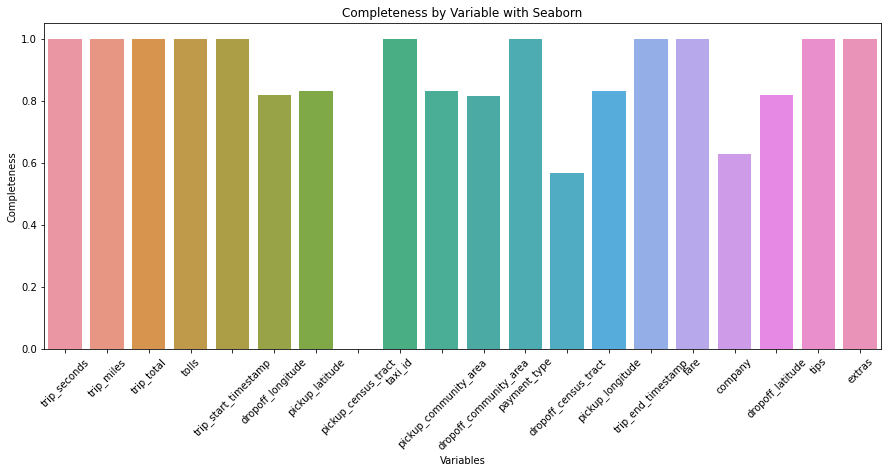

In [39]:
import seaborn as sns

# Création du barplot avec Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=reshaped_df.index, y=reshaped_df['Completeness'])
plt.xlabel('Variables')
plt.ylabel('Completeness')
plt.title('Completeness by Variable with Seaborn')
plt.xticks(rotation=45)
plt.show()

## Comparaison Uniqueness entre variables 

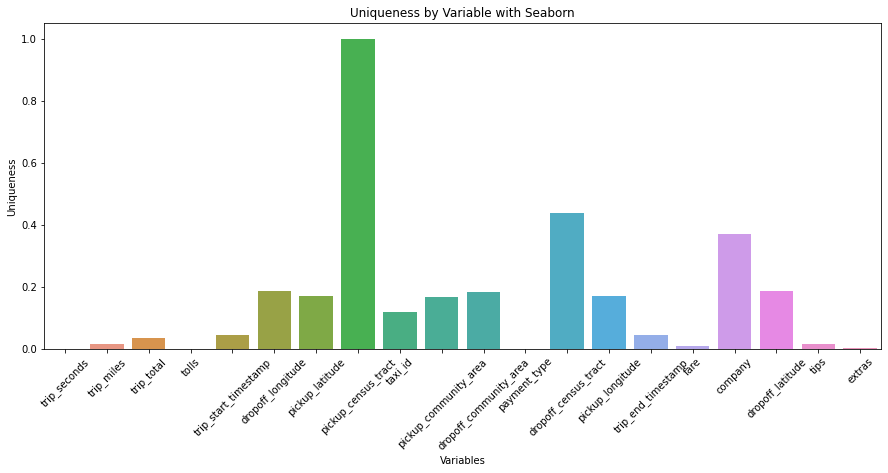

In [42]:
import seaborn as sns

# Création du barplot avec Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=reshaped_df.index, y=reshaped_df['Uniqueness'])
plt.xlabel('Variables')
plt.ylabel('Uniqueness')
plt.title('Uniqueness by Variable with Seaborn')
plt.xticks(rotation=45)
plt.show()

## Comparaison ApproxCountDistinct selon les variables

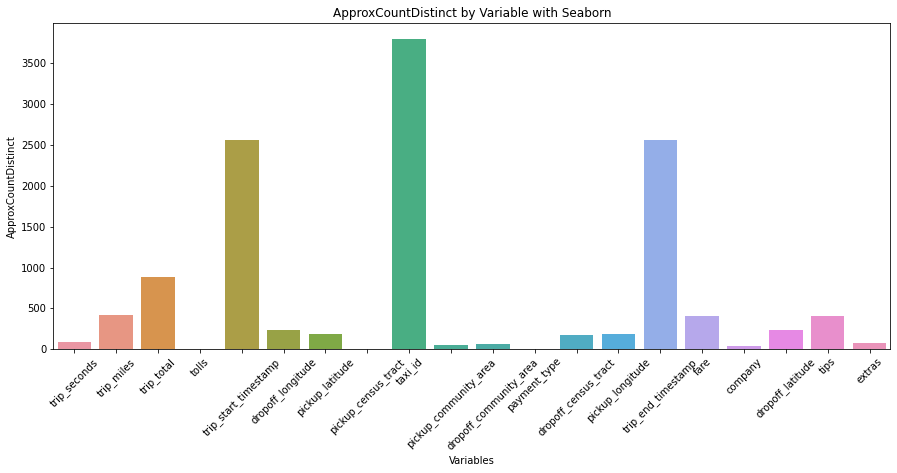

In [43]:
import seaborn as sns

# Création du barplot avec Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=reshaped_df.index, y=reshaped_df['ApproxCountDistinct'])
plt.xlabel('Variables')
plt.ylabel('ApproxCountDistinct')
plt.title('ApproxCountDistinct by Variable with Seaborn')
plt.xticks(rotation=45)
plt.show()

## Comparaison de la FRequent Ratio entre variables

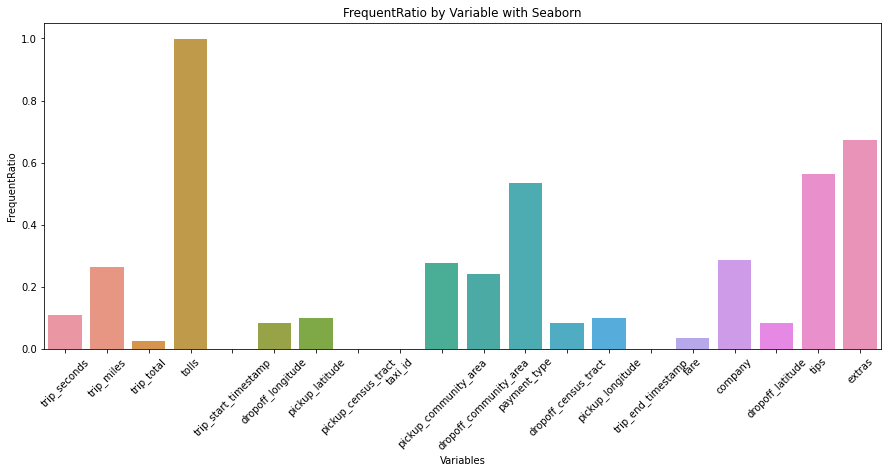

In [44]:
import seaborn as sns

# Création du barplot avec Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=reshaped_df.index, y=reshaped_df['FrequentRatio'])
plt.xlabel('Variables')
plt.ylabel('FrequentRatio')
plt.title('FrequentRatio by Variable with Seaborn')
plt.xticks(rotation=45)
plt.show()

## Comparaison de la Pecularity selon les variables

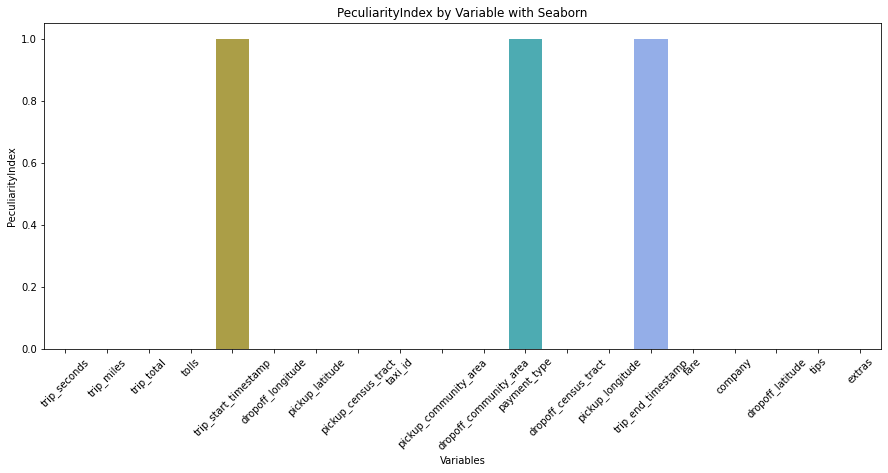

In [46]:
import seaborn as sns

# Création du barplot avec Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=reshaped_df.index, y=reshaped_df['PeculiarityIndex'].notna())
plt.xlabel('Variables')
plt.ylabel('PeculiarityIndex')
plt.title('PeculiarityIndex by Variable with Seaborn')
plt.xticks(rotation=45)
plt.show()

## Evolution de la completeness selon scalabilite

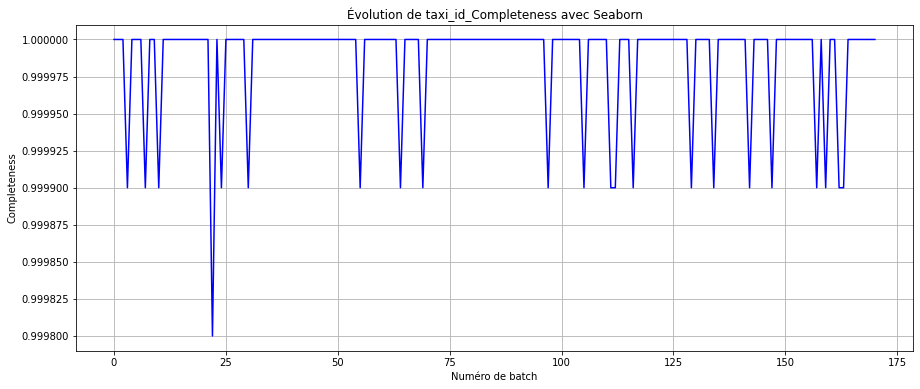

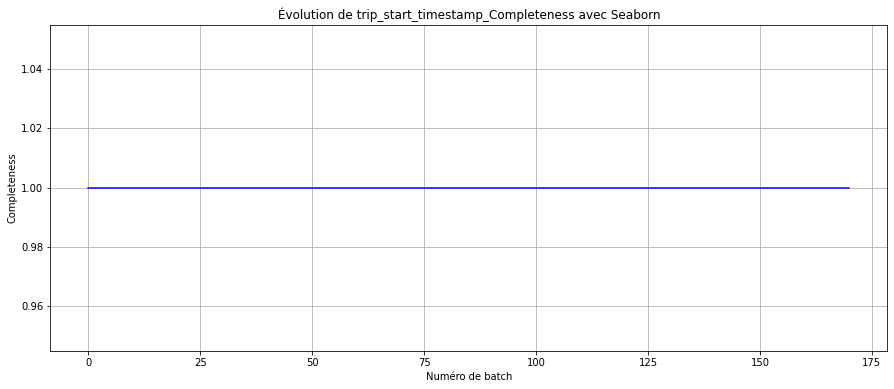

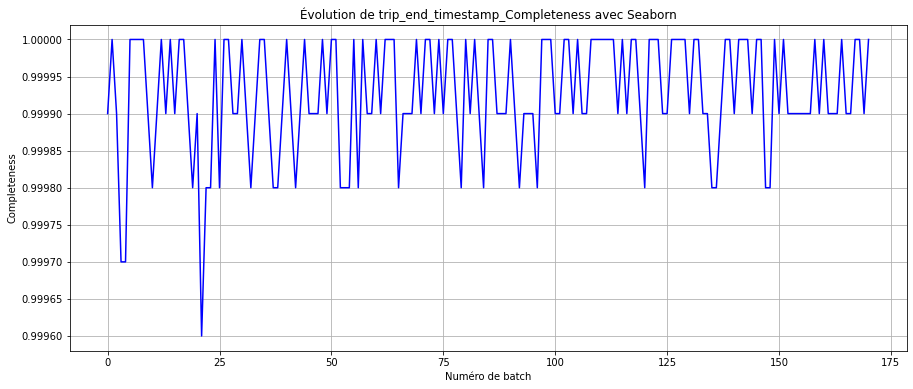

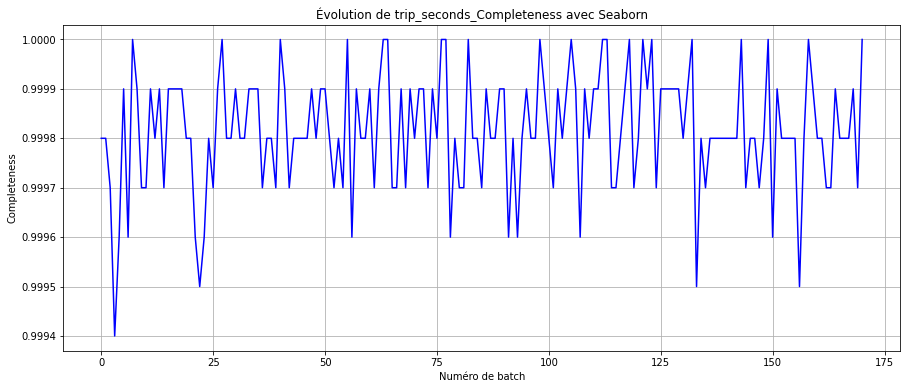

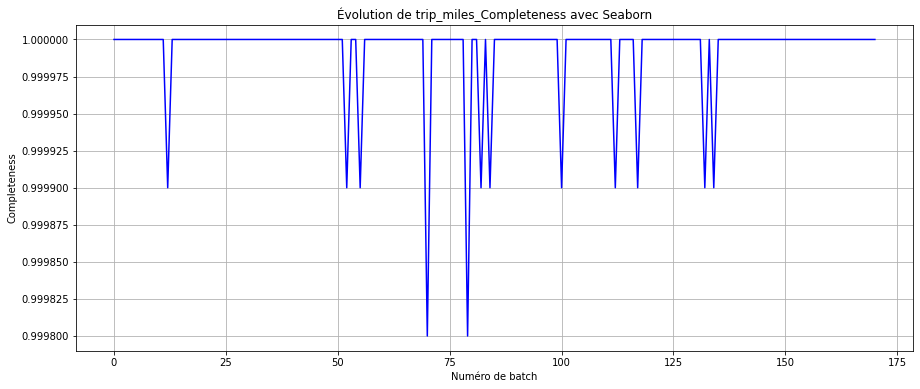

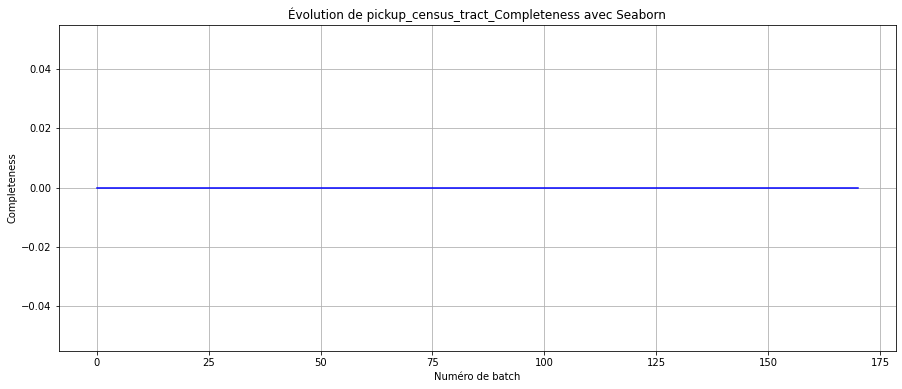

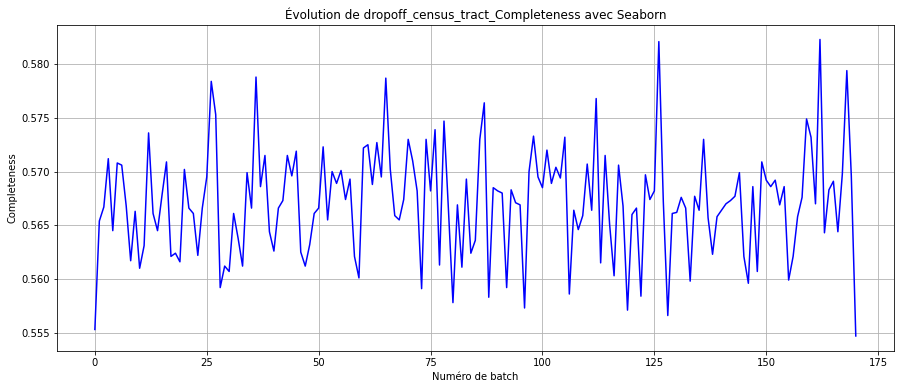

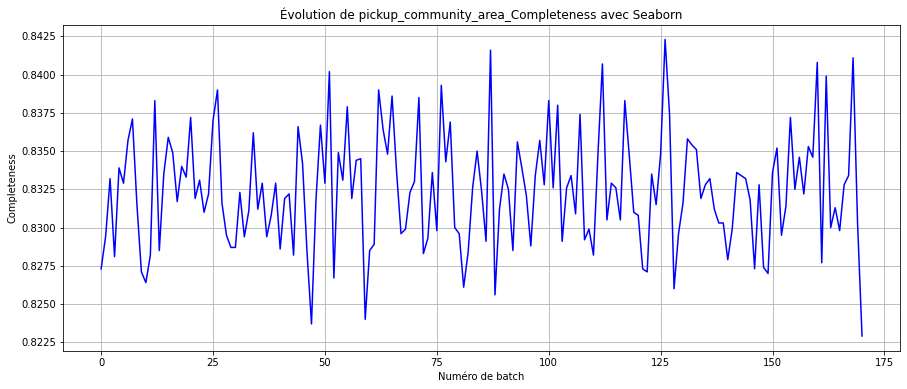

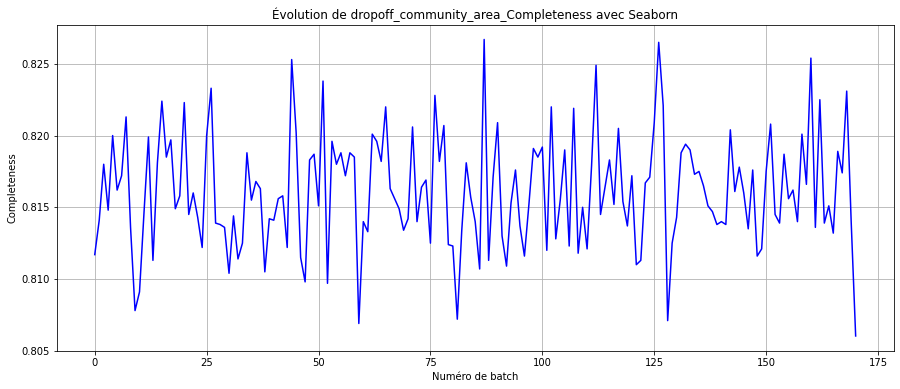

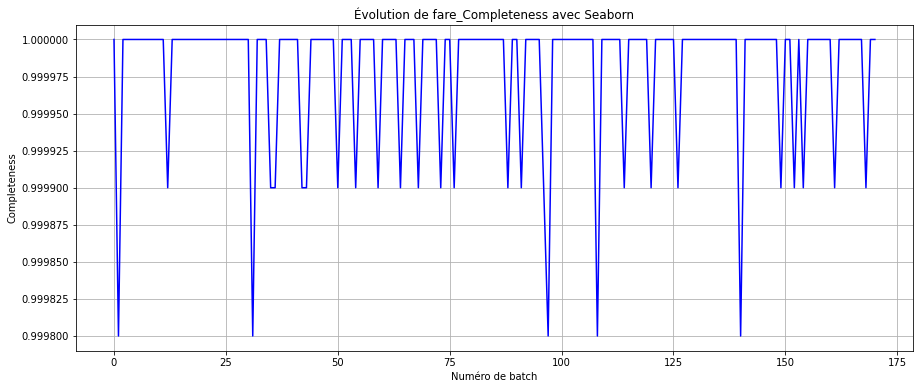

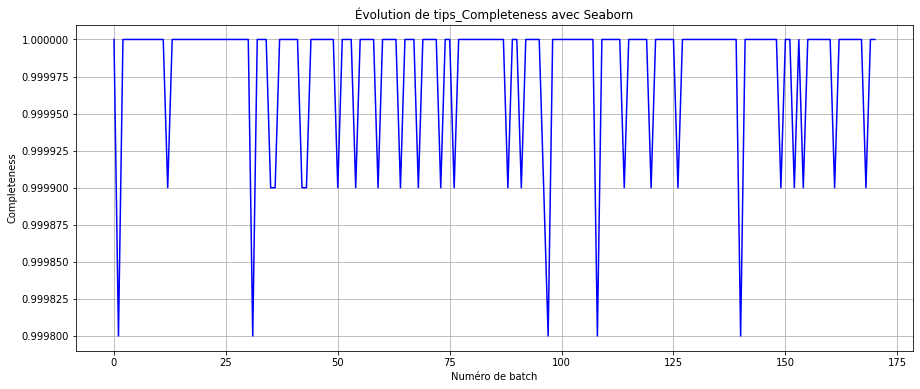

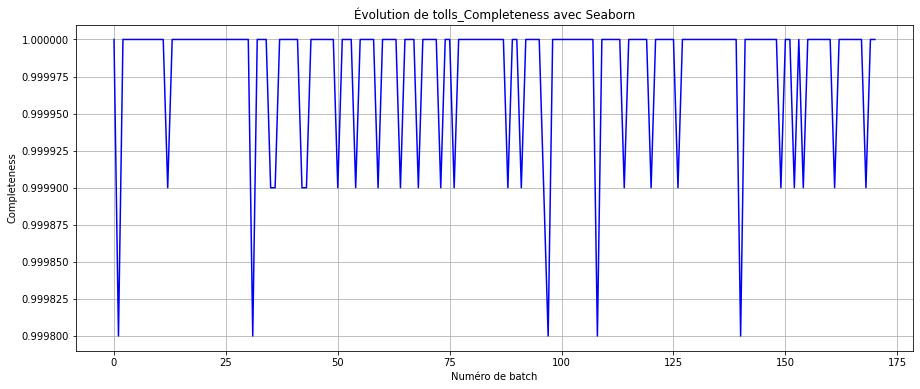

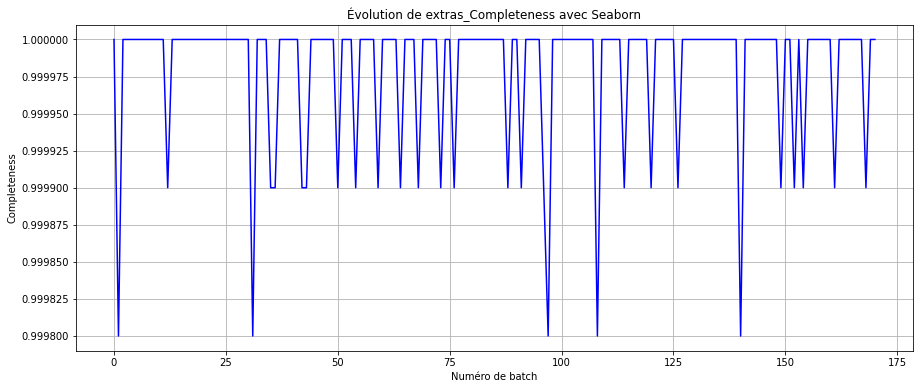

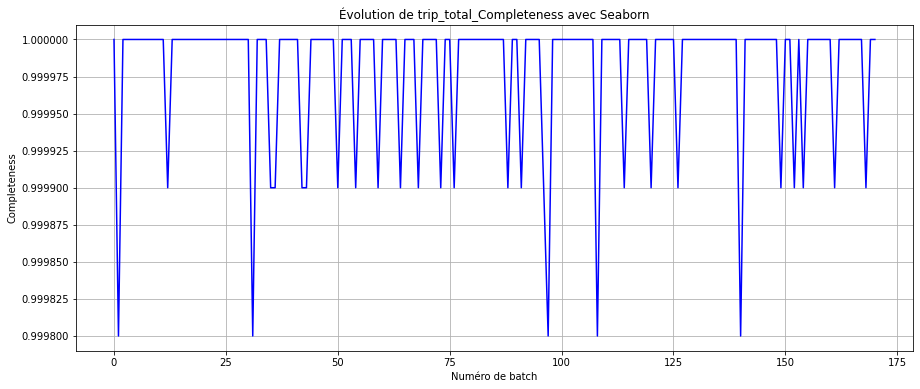

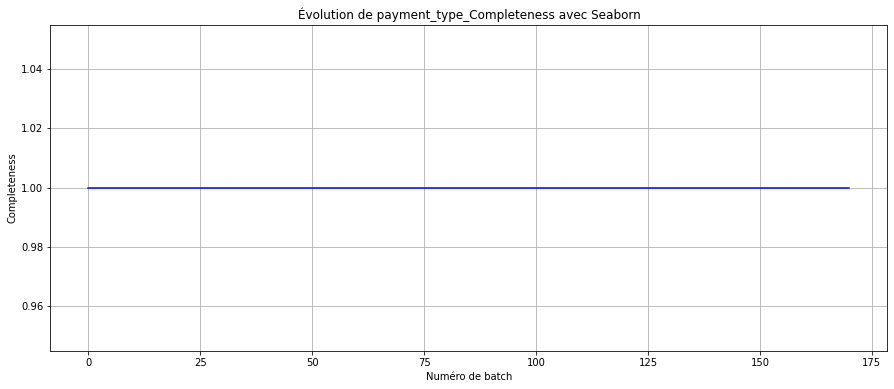

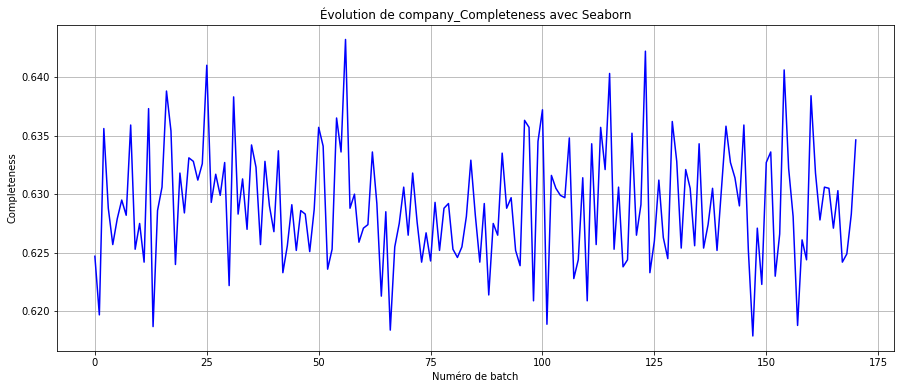

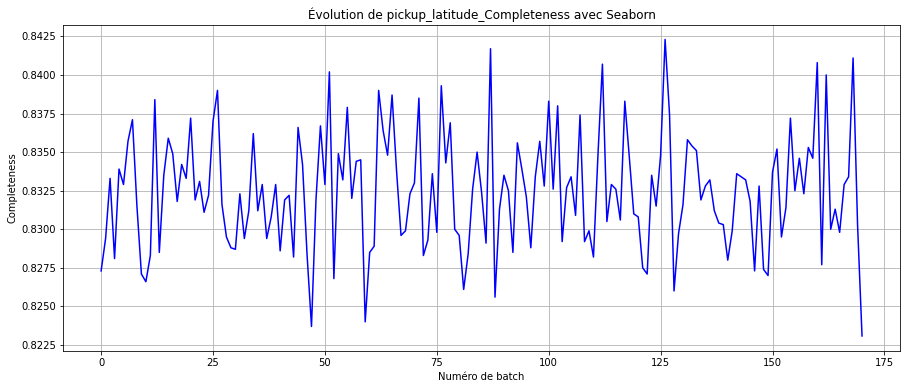

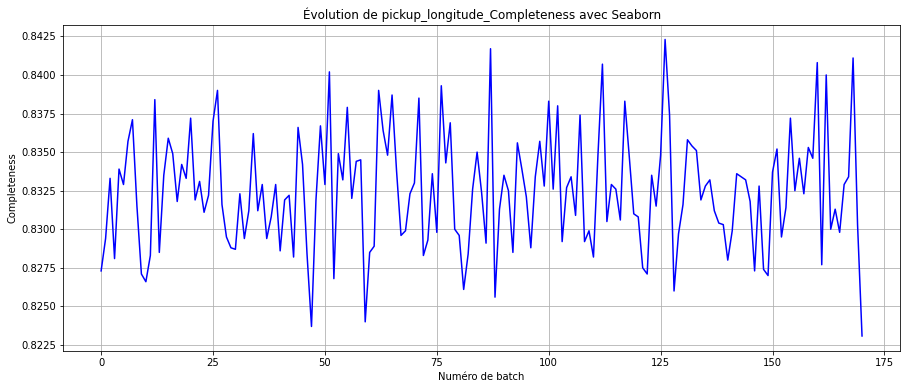

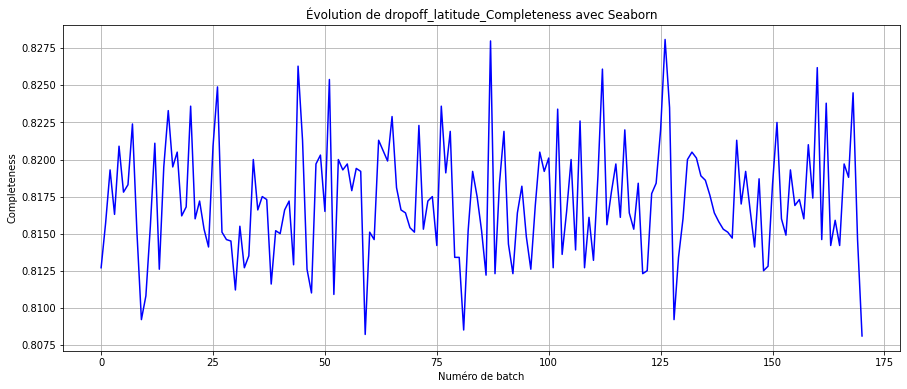

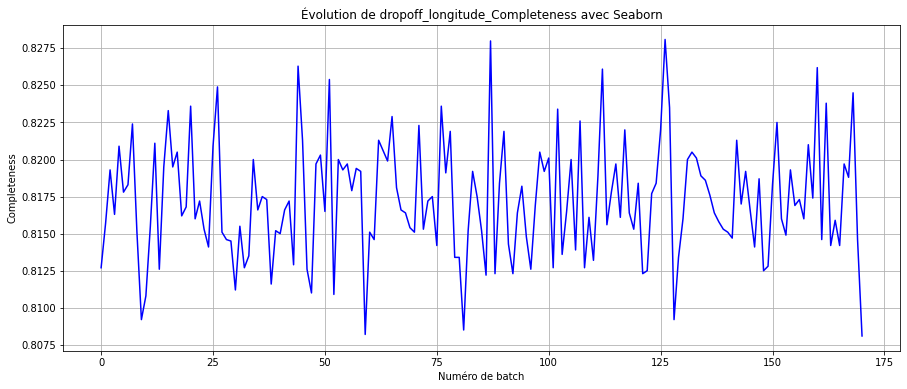

In [64]:
# Filtrage pour obtenir uniquement les colonnes se terminant par "_Completeness"
completeness_columns = [col for col in final_stats_df if col.endswith('_Completeness')]

for col in completeness_columns:
    # Utilisation de Seaborn pour le graphique
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=aggregated_stats[col], color='blue')
    plt.xlabel('Numéro de batch')
    plt.ylabel('Completeness')
    plt.title(f'Évolution de {col} avec Seaborn')
    plt.grid(True)
    plt.show()

## Evolution de l'Uniqueness selon scalabilite

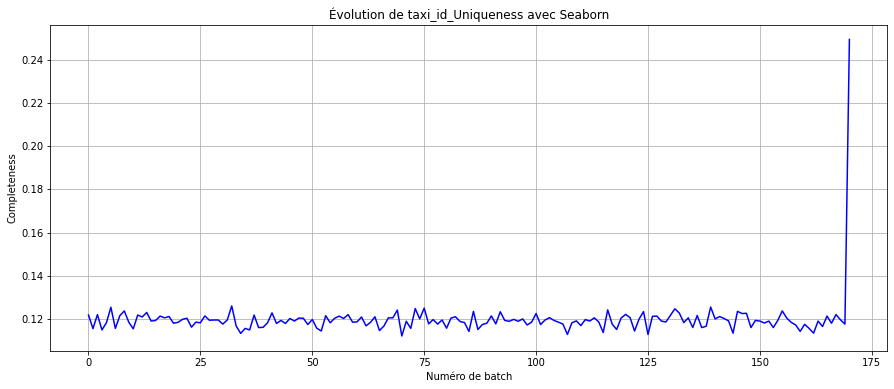

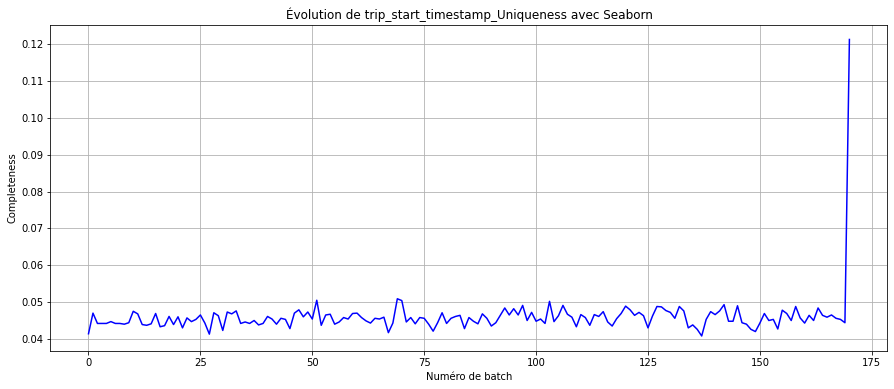

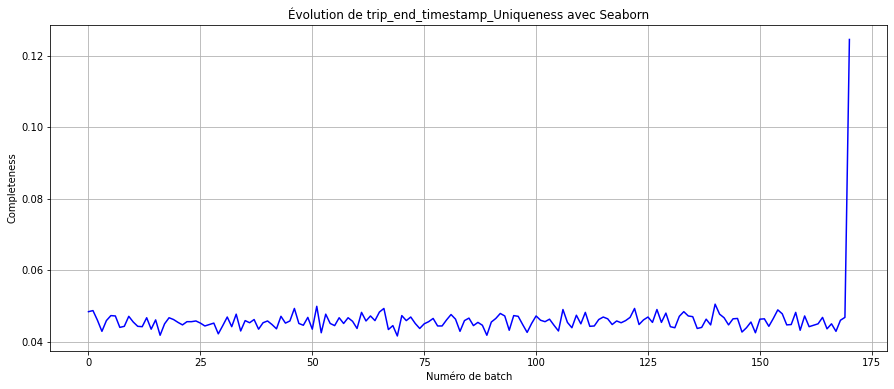

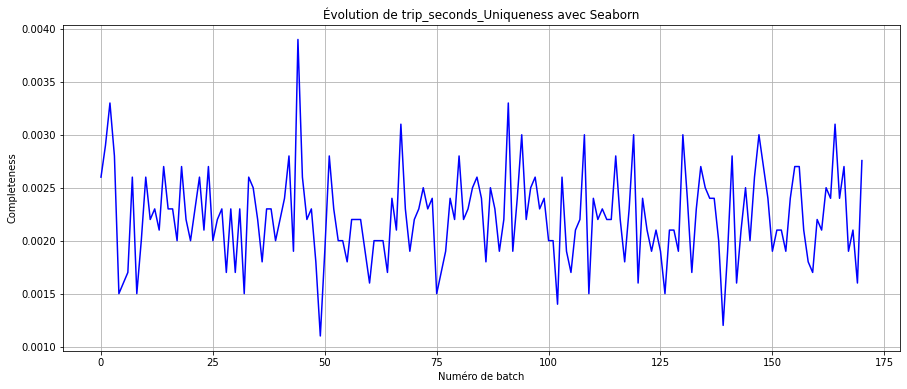

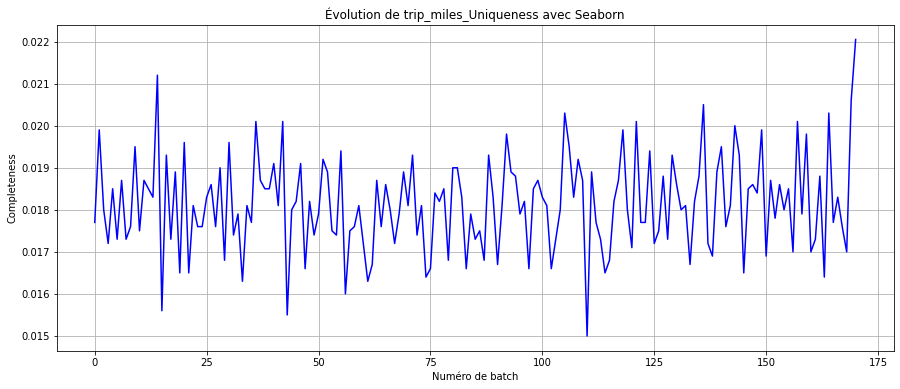

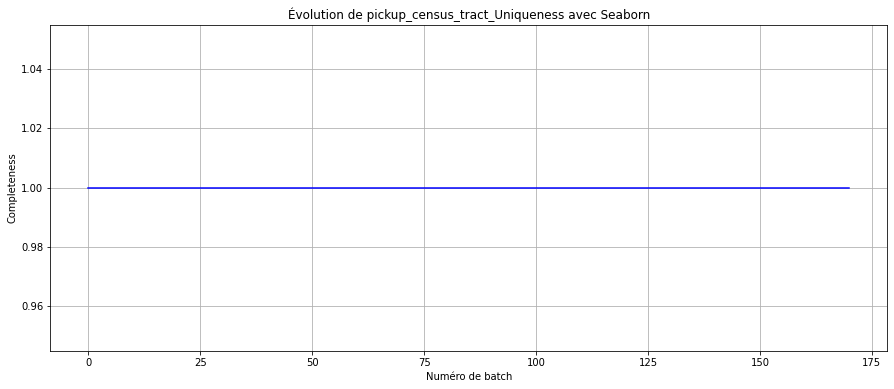

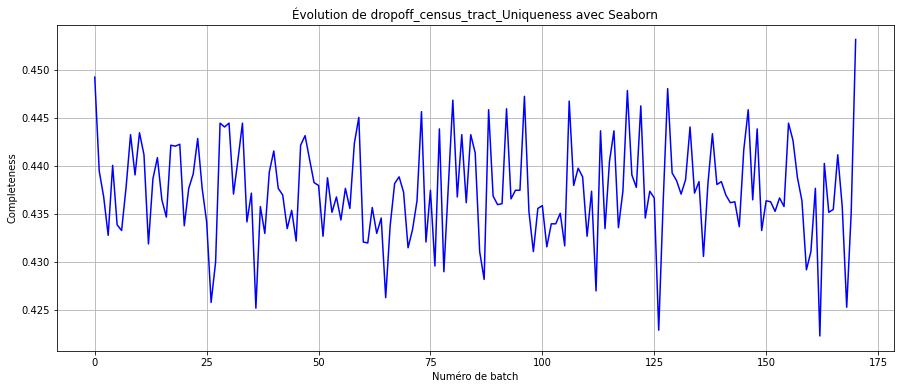

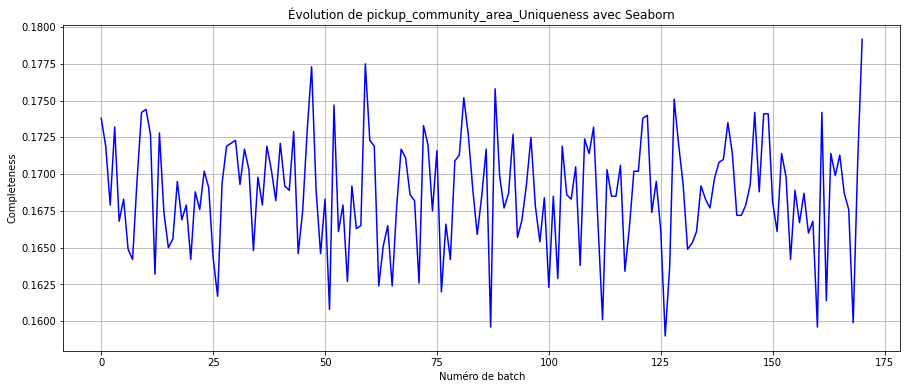

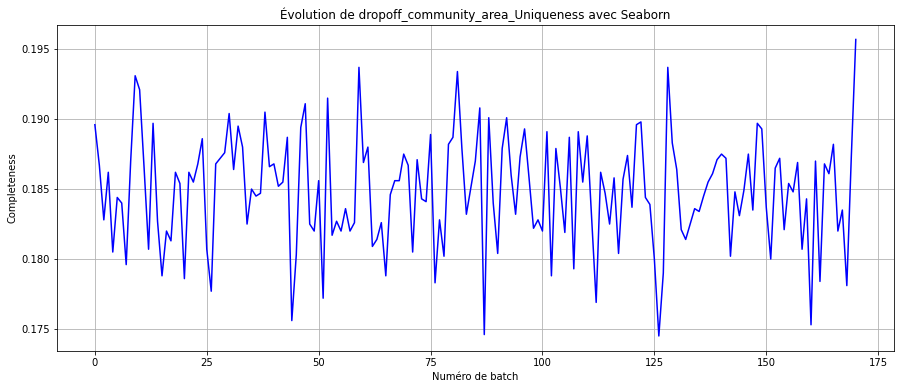

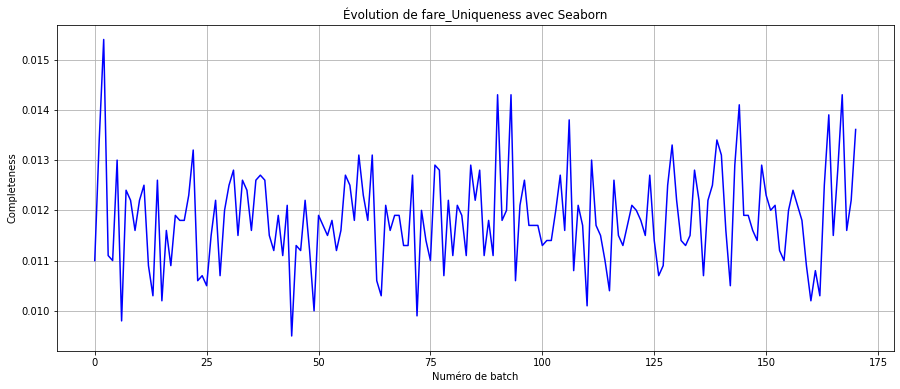

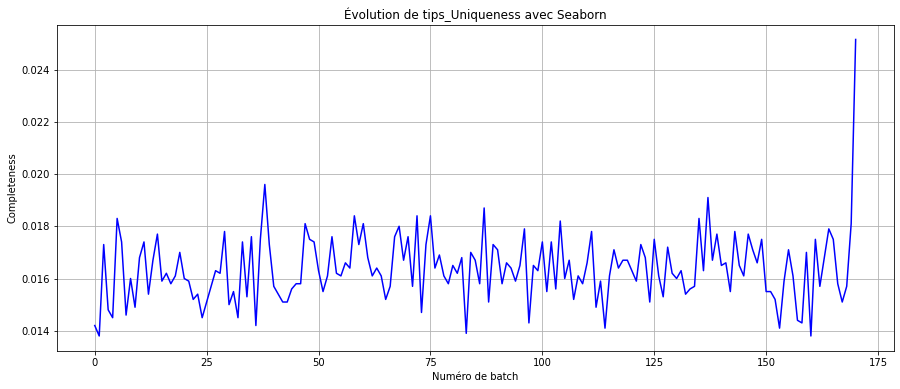

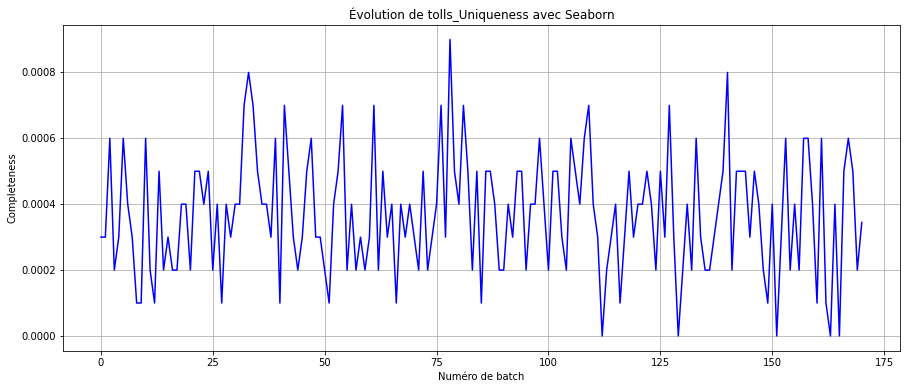

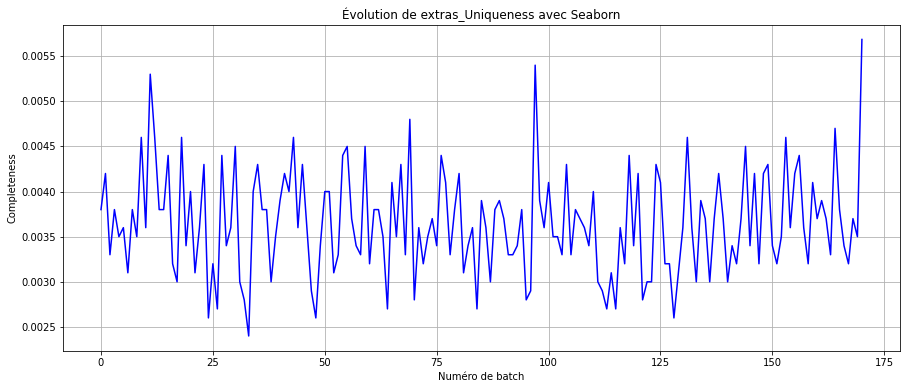

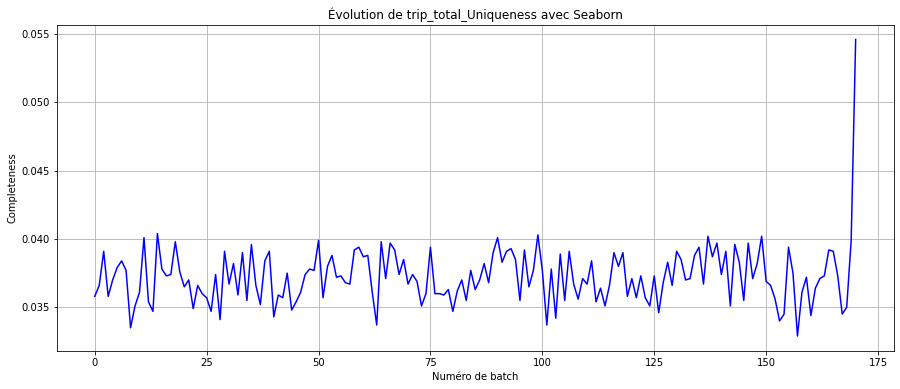

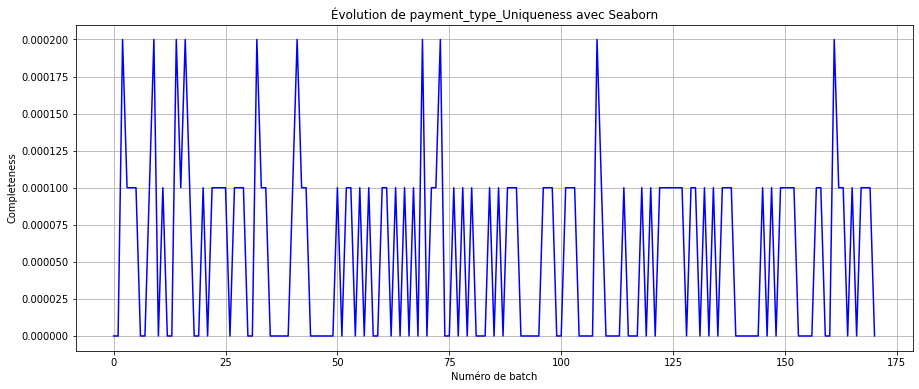

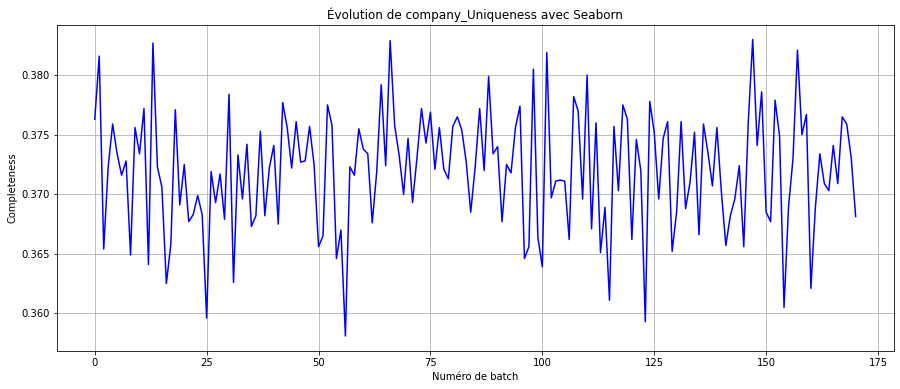

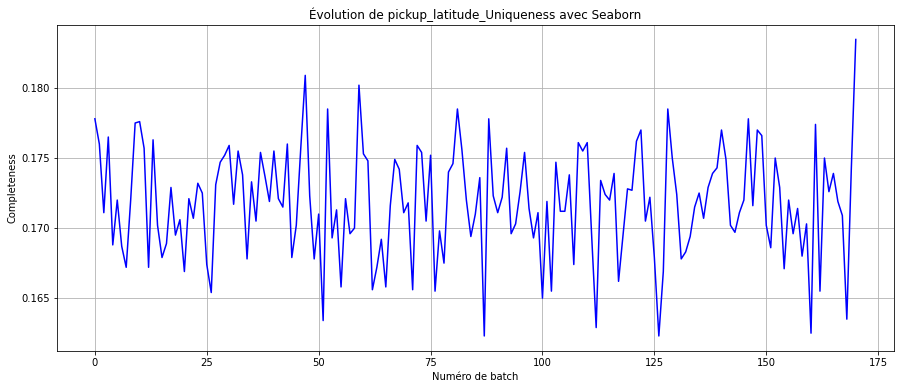

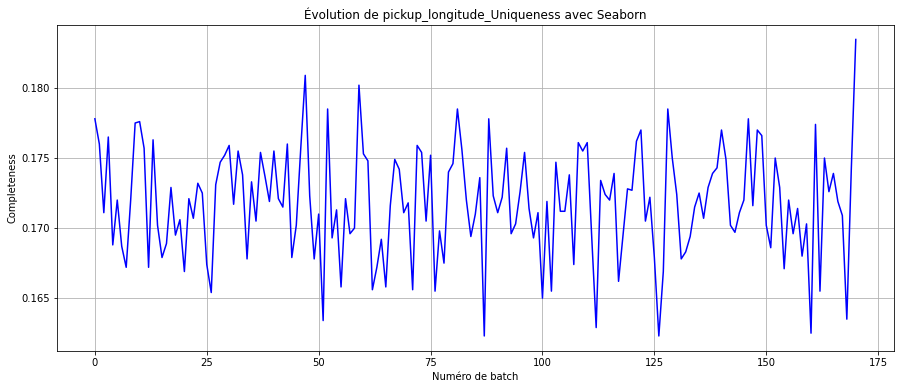

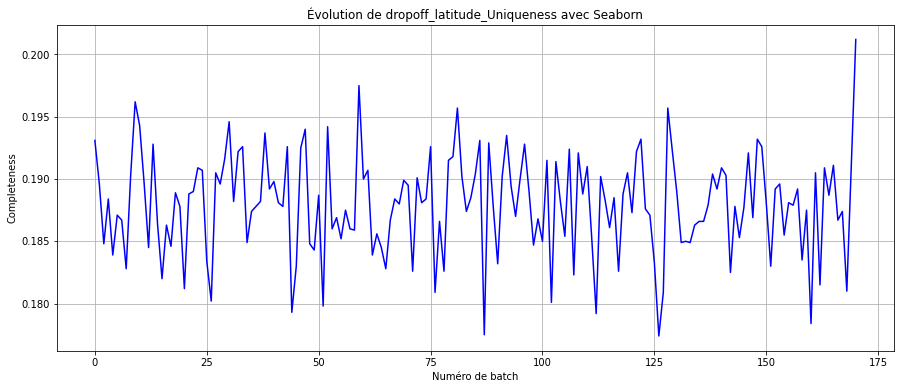

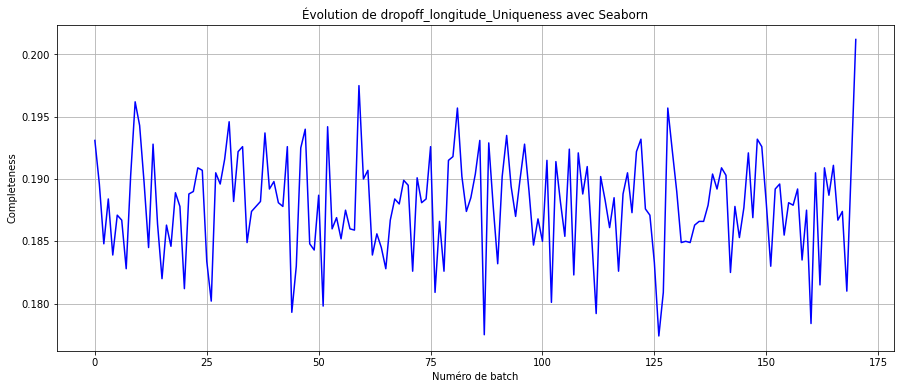

In [66]:
# Filtrage pour obtenir uniquement les colonnes se terminant par "_Uniqueness"
Uniqueness_columns = [col for col in final_stats_df if col.endswith('_Uniqueness')]

for col in Uniqueness_columns:
    # Utilisation de Seaborn pour le graphique
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=aggregated_stats[col], color='blue')
    plt.xlabel('Numéro de batch')
    plt.ylabel('Completeness')
    plt.title(f'Évolution de {col} avec Seaborn')
    plt.grid(True)
    plt.show()

## Evolution de la Frequent Ratio de chaque variable avec scalabilite

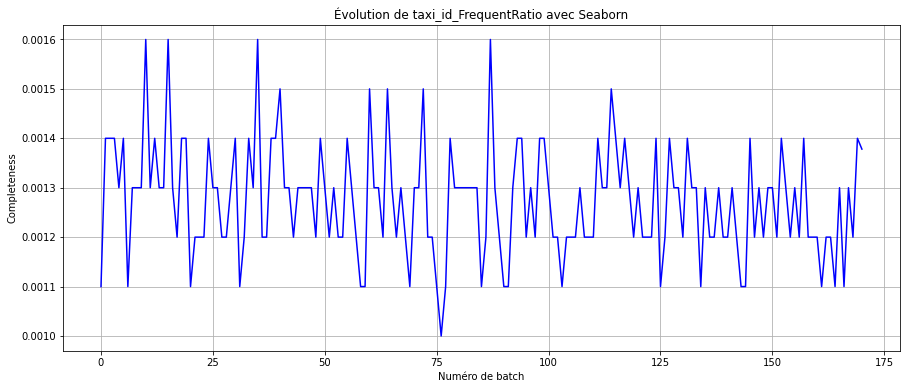

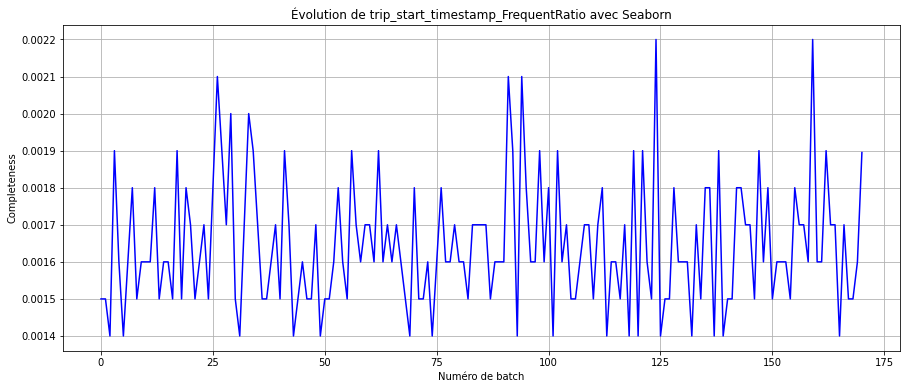

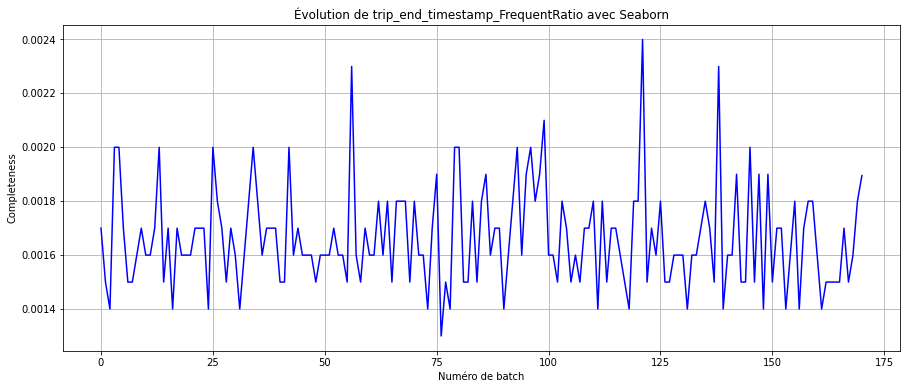

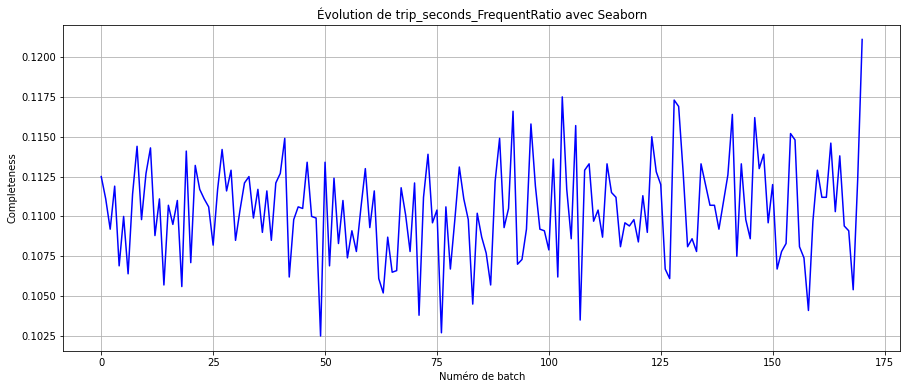

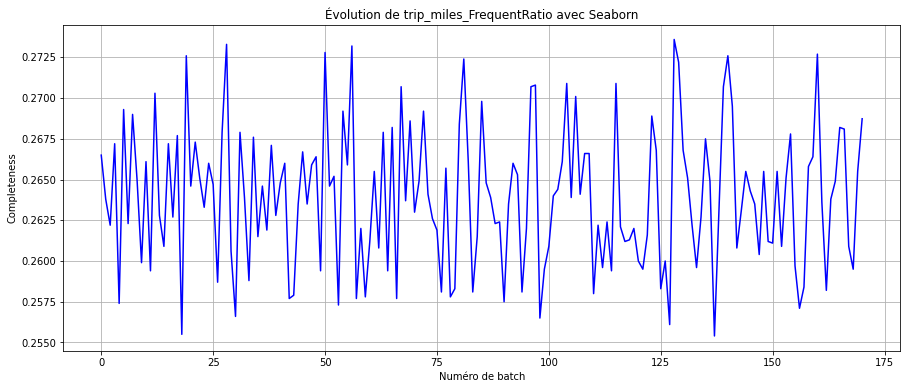

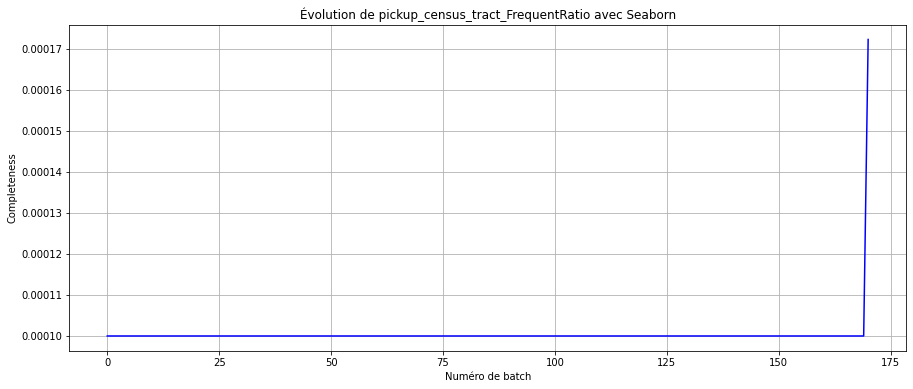

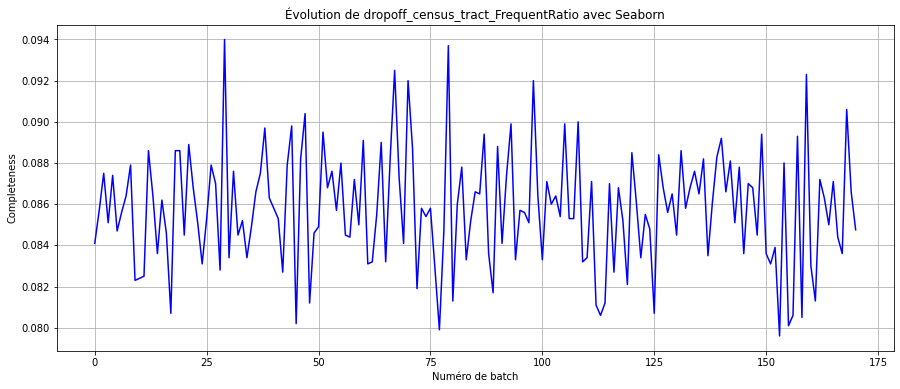

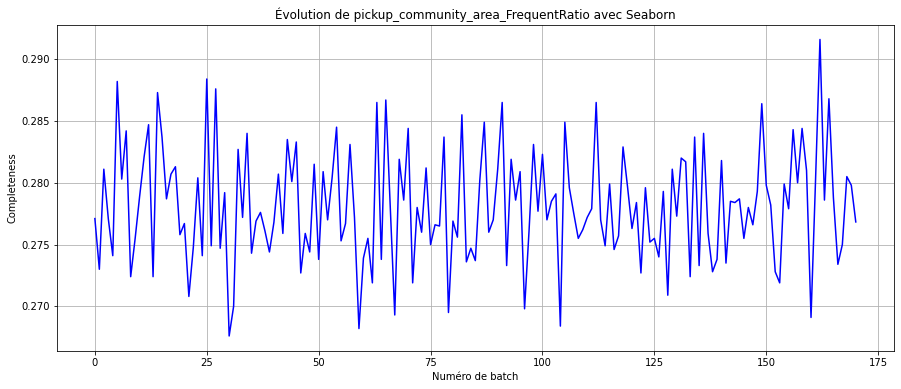

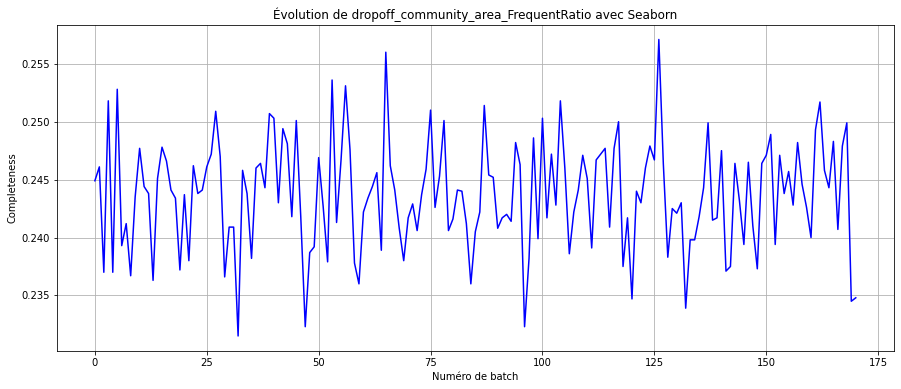

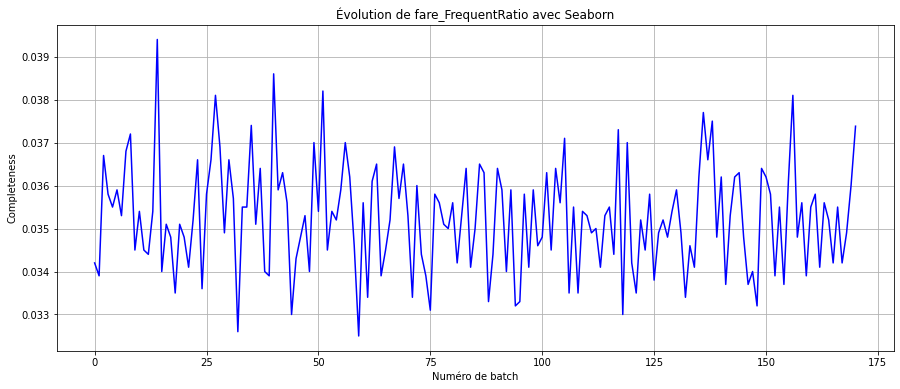

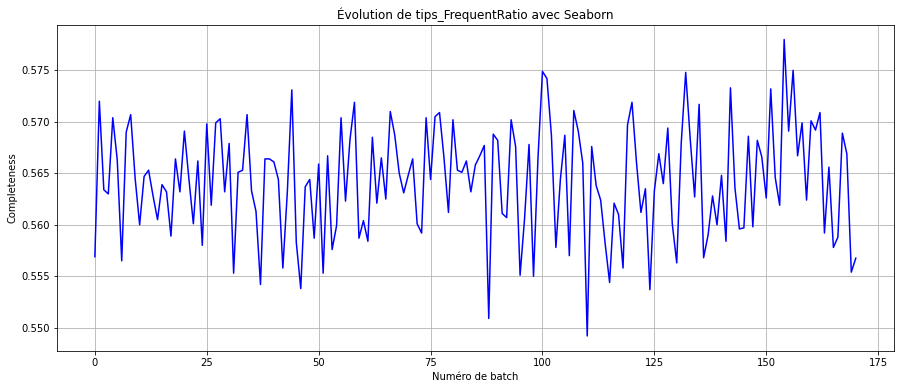

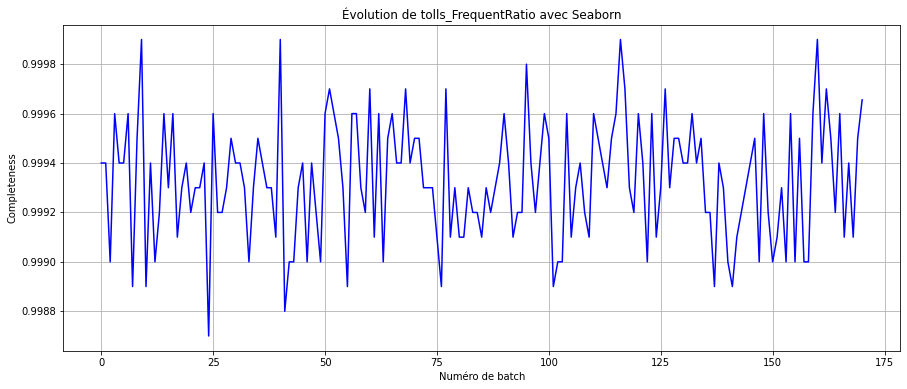

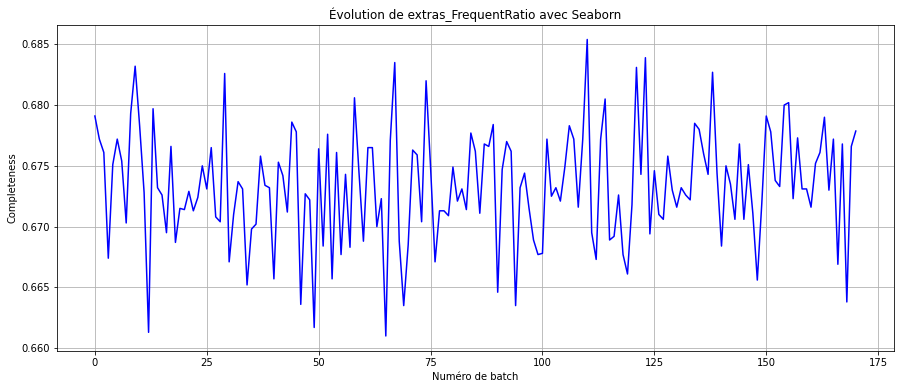

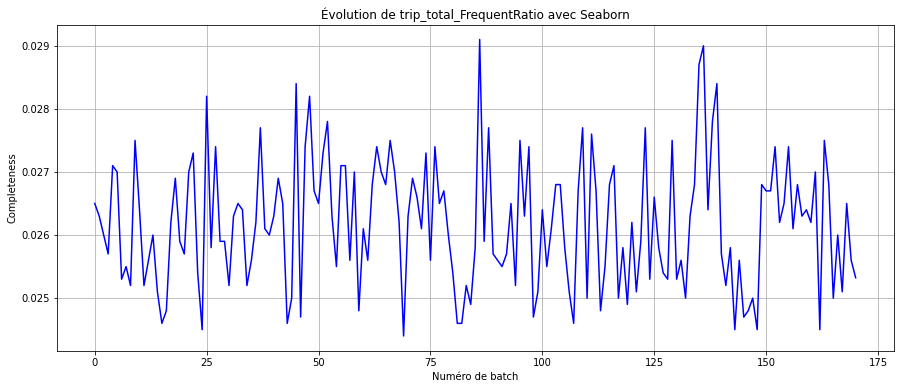

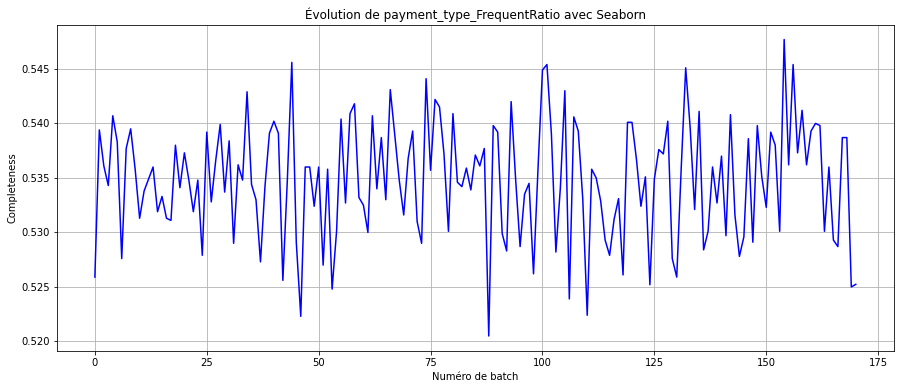

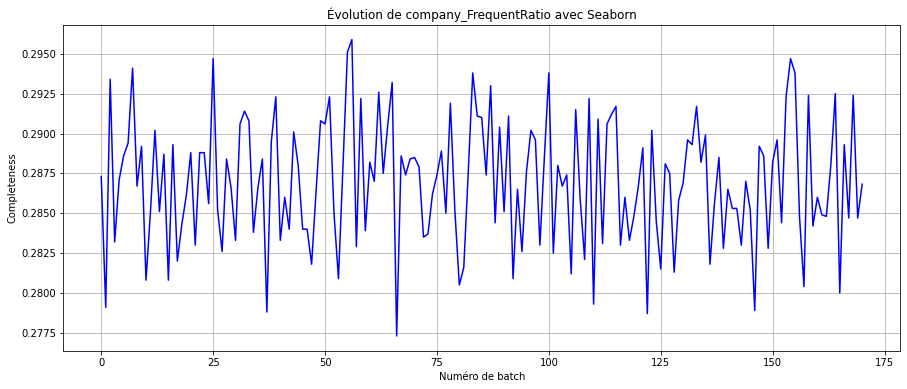

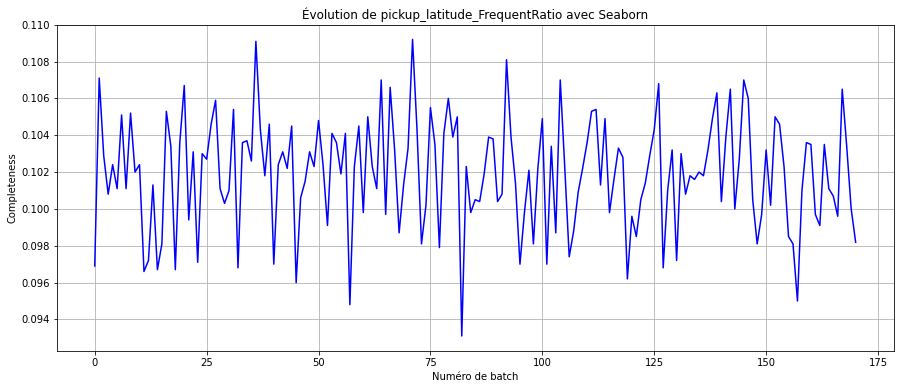

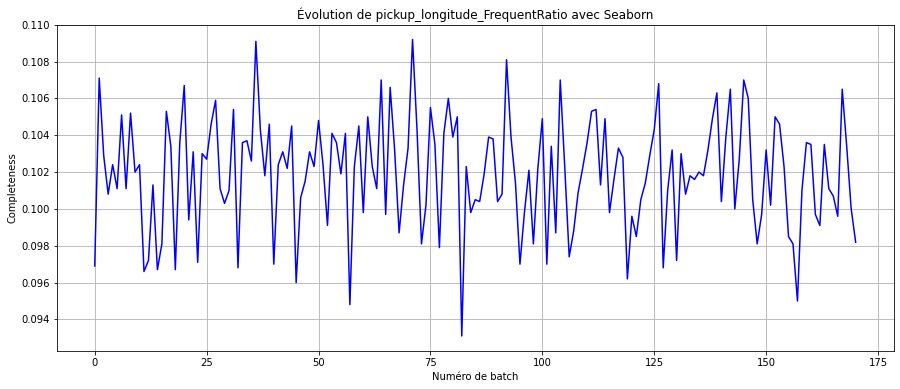

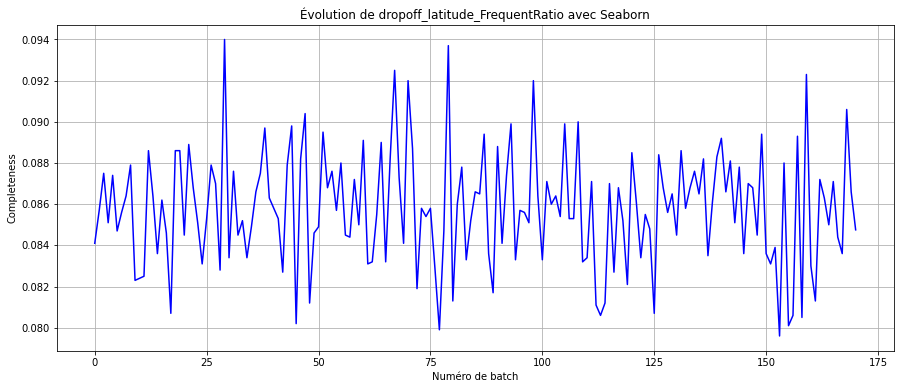

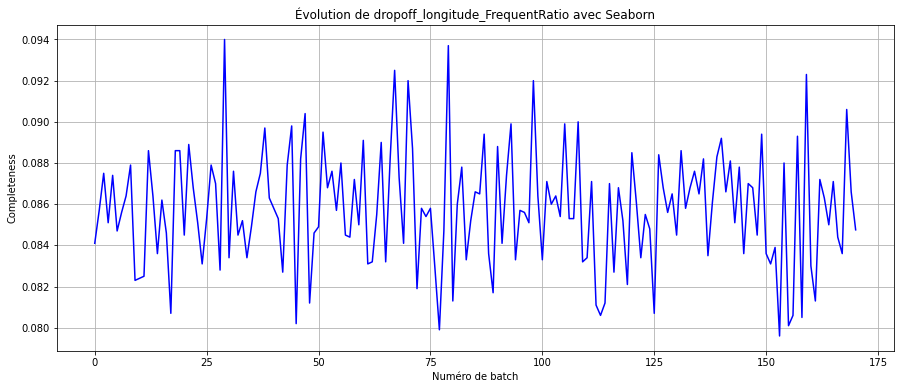

In [67]:
# Filtrage pour obtenir uniquement les colonnes se terminant par "_FrequentRatio"
FrequentRatio_columns = [col for col in final_stats_df if col.endswith('_FrequentRatio')]

for col in FrequentRatio_columns:
    # Utilisation de Seaborn pour le graphique
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=aggregated_stats[col], color='blue')
    plt.xlabel('Numéro de batch')
    plt.ylabel('Completeness')
    plt.title(f'Évolution de {col} avec Seaborn')
    plt.grid(True)
    plt.show()

## Demo 

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DataQualityValidator:
    def __init__(self):
        self.clf = KNNLearner()
        self.history = []

    def preprocess_data(self, data):
        # Convert list to NumPy array and reshape it to 2D if it's a 1D array
        data = np.array(data)
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        # Handling NaNs and infinities
        imputer = SimpleImputer(strategy='mean')
        data = imputer.fit_transform(data)
        data = np.nan_to_num(data)

        # Scaling data
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)

        return data

    def train(self, test_size=0.2):
        combined_history = np.vstack(self.history)
        X_train, X_test = train_test_split(combined_history, test_size=test_size)
        self.clf.fit(X_train)
        predictions = self.clf.predict(X_test)
        accuracy = accuracy_score(X_test, predictions)
        print(f"Training Accuracy: {accuracy}")
        return accuracy

    def test(self, batch):
        processed_batch = self.preprocess_data(batch)
        decision = self.clf.predict([processed_batch])
        return Quality.GOOD if int(decision) == 0 else Quality.BAD
    
    def add(self, batch):
        processed_batch = self.preprocess_data(batch)
        self.history.append(processed_batch)




In [25]:
def demo_taxi_trip(file_path, batch_size=1000):
    dqv = DataQualityValidator()
    batches = get_taxi_trip_batches(file_path, batch_size)

    # Initial Training Phase
    for _ in range(8):
        batch_data = next(batches)
        profile = DataProfiler().compute_for(batch_data)
        dqv.add(profile)

    # Training with Validation
    dqv.train(test_size=0.2)

    # Testing Phase
    for batch_data in batches:
        profile = DataProfiler().compute_for(batch_data)
        res = dqv.test(profile)
        if res == Quality.GOOD:
            dqv.add(profile)
            print('Good')
        else:
            print('**** Potential problem with a batch!')

if __name__ == "__main__":
    file_path = 'archive/combined_dataset.csv'
    demo_taxi_trip(file_path)



ValueError: Classification metrics can't handle a mix of continuous and binary targets